# Bayesian Parameter Estimation
## Nathan Belliveau, Griffin Chure, Manuel Razo

In [1]:
import os
import glob
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
# Library to perform MCMC runs
import emcee

import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Defining the problem

As defined for the [non-linear regression](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/non_linear_regression.ipynb) we want to obtain the **M**aximum **ap**osteriori (MAP) value for two of the parameters in the MWC model for the induction of the *lac* repressor in a simple repression architecture.

Our theoretical model dictates that the fold change in gene expression is given by

\begin{equation}
    \text{fold-change} = \frac{1}{1 + \frac{2R p_{act}(C)}{N_{NS}} \left( 1 + e^{-\beta \Delta \epsilon_{ai}} \right)  e^{-\beta \Delta \epsilon_r}},
\end{equation}

where $p_{act}(C)$ is given by

\begin{equation}
    p_{act}(C) = \frac{\left( 1 + C e^{\epsilon_A}\right)^2}{\left( 1 + C e^{\epsilon_A}\right)^2 + e^{-\beta \epsilon_{ai}} \left( 1 + C e^{\epsilon_I}\right)^2}.
\end{equation}

We define $\epsilon_A = -\ln K_A$ and $\epsilon_I = -\ln K_I$ for convenience.

If we want to fit the parameters $\epsilon_A$ and $\epsilon_I$, by Bayes theorem we have that

\begin{equation}
P(\epsilon_A, \epsilon_I \mid D, I) \propto P(D \mid \epsilon_A, \epsilon_I, I) \cdot P(\epsilon_A, \epsilon_I \mid I),
\end{equation}

where $D$ is the experimental data and $I$ is all the previous information.

# First approach to the problem:
## Gaussian likelihood and constant error

The simplest model would consist on the following asusmptions:
1. each measurement is independent
2. the errors are Gaussian distributed
3. the error distribution is homoscedastic, i.e. this error is constant along the range of IPTG.

We will relax this third assumption later on, but for now this is the easiest zero-order approximation we want to implement. This problem with these assumptions **is analytically tractable** but we will solve it using MCMC to get us going with the technique.

It is important to indicate that each element of $D$ is a "pair" of a dependent variable (the experimental fold change $fc_{exp}$) and the independent variables (the repressor copy number $R$, the binding energy $\Delta \epsilon_r$ and the IPTG concentration $C$). With this in hand we implement the first assumption as

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)}, I),
\end{equation}

where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

Implementing the second and third assumption we obtain

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, \sigma, I) = \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right],
\end{equation}

where we include the parameter $\sigma$ associated with the Gaussian distributed error.

For the priors we can assume that the 3 parameters $\epsilon_A, \epsilon_I$ and $\sigma$ are not only independent, but since they have a uniform prior in log scale they can have a Jeffres' prior, i.e.

\begin{equation}
P(\epsilon_A, \epsilon_I, \sigma \mid I) \equiv \frac{1}{\epsilon_A}\cdot\frac{1}{\epsilon_I}\cdot\frac{1}{\sigma}
\end{equation}

Putting all the pieces together we can compute the posterior distribution as

\begin{equation}
P(\epsilon_A, \epsilon_I, \sigma \mid D, I) \propto \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right] \frac{1}{\epsilon_A}\cdot\frac{1}{\epsilon_I}\cdot\frac{1}{\sigma}
\end{equation}

### The MCMC approach to the problem.

Before when we tackled this problem analytically we had to integrate out the nuance parameter $\sigma$ out of the distribution. but now since we will be using MCMC all we have to do is to define the log probability $\ln P(\epsilon_A, \epsilon_I, \sigma \mid D, I)$ and let the computer do the nasty integration for us.

The big advantage of this approach is that it relegates the heavy math required to perform these integrations, and allows the computer to solve the problem numerically for us. This will be very handy once we start to relax some of the assumptions in the model.

As for now let's define the log probability distribution!

In [2]:
def log_likelihood(param, indep_var, dep_var, epsilon=4.5):
    """
    Computes the log likelihood probability.
    Parameteres
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # unpack parameters
    ea, ei, sigma = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var.iloc[:, 0],\
                         indep_var.iloc[:, 1],\
                         indep_var.iloc[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r)
   
    log_like =  np.sum((fc_theory - dep_var)**2) / 2 / sigma**2
    return log_like
   
def log_post(param, indep_var, dep_var, epsilon=4.5,
             ea_range=[6 -6], ei_range=[6, -6], sigma_range=[0, 1]):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    ea_range : array-like.
        Range of variables to use in the prior as boundaries for the ea parameter.
    ei_range : array-like.
        Range of variables to use in the prior as boundaries for the ei parameter.
    sigma_range : array-like.
        Range of variables to use in the prior as boundaries for the sigma param.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    '''
    # unpack parameters
    ea, ei, sigma = param
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if ea > np.max(ea_range) or ea < np.min(ea_range)\
    or ei > np.max(ei_range) or ea < np.min(ei_range)\
    or sigma > np.max(sigma_range) or sigma < np.min(sigma_range):
        return -np.inf
    
    return -(len(indep_var) + 1) * np.log(sigma) \
    - log_likelihood(param, indep_var, dep_var, epsilon)

## Running the MCMC on the data 
Now that we defined our functions, let's test it on the experimental data we have gathered so far.

In [3]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + 'O2_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]

df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160805,mrazomej,O2,-13.9,RBS1L,870,0.0,3586.277698,132.792582,0.007538
3,20160805,mrazomej,O2,-13.9,RBS1,610,0.0,3591.757405,138.272290,0.007849
4,20160805,mrazomej,O2,-13.9,RBS1027,130,0.0,3715.043175,261.558059,0.014847
5,20160805,mrazomej,O2,-13.9,RBS446,62,0.0,3985.805741,532.320626,0.030216
6,20160805,mrazomej,O2,-13.9,RBS1147,30,0.0,4376.824276,923.339160,0.052411


The log posterior takes as arguments the parameters, and a series of independent and dependent variables. The independent variables are the IPTG concentration, the repressor copy number and the binding energy of the repressor to the operator.

Let's extract those features from the data for only one strain.

In [4]:
# extracting independent and dependent variables
indep_var = df[df.rbs=='RBS1027'][['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = df[df.rbs=='RBS1027'].fold_change_A

Now let's define all the necessary stuff to run the MCMC.

To initialize the walkeres we will "cheat", meaning that we will use the non-linear regression approach to find the MAP and then initialize the walkers within that region using `numpy`'s `multivariate_normal` sampler.

In [5]:
# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(df[df.rbs=='RBS1027'],
                                 p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

In [6]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

Let's instanciate the sampler

In [7]:
# Set the ranges for the MCMC
ea_range = [-7, 7]
ei_range = [-7, 7]
sigma_range = [0, df.groupby('rbs').fold_change_A.std().max()]
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(indep_var, dep_var, 4.5, ea_range, ei_range, sigma_range),\
                threads=6)

Perform the burn-in steps.

In [8]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

Once we do the burn-in steps let's now run the real MCMC routine!

In [9]:
# Perform the real MCMC
_ = sampler.run_mcmc(pos, n_steps)

Let's visualize the results!

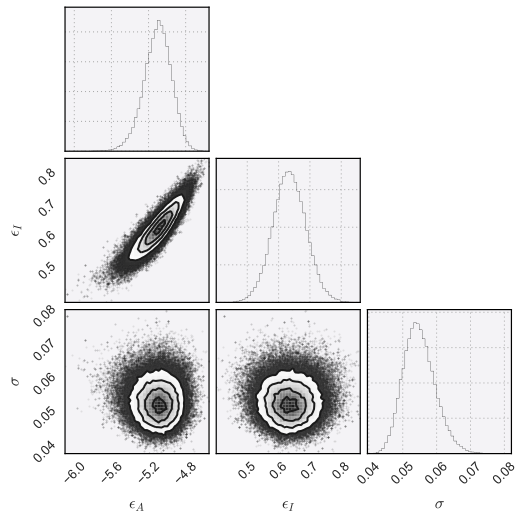

In [11]:
fig = corner.corner(sampler.flatchain, bins=50, plot_contours=True,
                   labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\sigma$'])

### Reporting the results.

To report the output of the MCMC routine we will use the HPD. As explained in [this tutorial](http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html)
>This method uses the highest posterior density interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. So, we report the mode and then the bounds on the HPD interval.

We will use the same funciton used in the tutorial to compute the HPD from the MCMC chain.

In [25]:
# map value of the parameters
ea, ei = np.mean(sampler.flatchain[:, [0, 1]], axis=0)
Ka, Ki = np.exp(-ea), np.exp(-ei)
# ea range
ea_hpd = mwc.hpd(sampler.flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(sampler.flatchain[:, 1], 0.95)
Ka_hpd = np.exp(-ea_hpd)
Ki_hpd = np.exp(-ei_hpd)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +{1:0.3f} -{2:0.3f} uM
Ki = {3:.5f} +{4:0.6f} -{5:0.6f} uM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 164.84 +57.437 -41.843 uM
Ki = 0.53001 +0.059283 -0.052328 uM



# Second approach:
## Cauchy likelihood (for outliers)

A different approach to the problem is to consider that the residuals, i.e. the difference between our theoretical model and the data, have a Cauchy distribution rather than a Gaussian.

The difference in this approach is that the Cauchy distribution has very long tails compare to the Gaussian distribution. This allows "outliers to exist" but gives them a very small weight when performing the fitting. This is different to what the Gaussian likelihood would do where an outlier is such an incredibly rare event, that every data point that you see must be basically "real" and therefore tries to fit the model giving very similar weight to all the data points.

The assumptions of the model can again be listed as
1. each measurement is independent.
2. the errors are **Cauchy** distributed.
3. the error distribution is homoscedastic, i.e. this error is constant along the range of IPTG.

With this in hand we implement the first assumption as

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)}, I),
\end{equation}

where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

Implementing the second and third assumption we obtain

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, \beta, I) = \frac{1}{\beta} \prod_{i = 1}^n \left[ \pi \beta \left(1 + \left( \frac{fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right)}{\beta} \right)^2 \right) \right]^{-1}
\end{equation}

where we include the parameter $\beta$ associated with the Cauchy distribution.

We can again assume Jeffrey's priors for all 3 parameters and define again the log-likelihood to perform the MCMC run.